In [1]:
# Instalação e configuração de variaveis ambiente para utilizar Google Drive
# Se utilizar o Colab ajustar para True para instalação dos pre-requisitos
colab = True

if colab==True:
  from google.colab import drive
  drive.mount('/content/drive')

  # Google Drive
  dir_base = "/content/drive/MyDrive/jupyter/pcd_porto_seguro_safe_driver_prediction/data/"
  # raiz
  dir_base_root = "/content/drive/MyDrive/jupyter/pcd_porto_seguro_safe_driver_prediction/"
  import sys
  # caution: path[0] is reserved for script path (or '' in REPL)
  sys.path.append(dir_base_root)

  # Insalar depedências


else:
  # Diretorio da base dos dados
  # Local PC
  dir_base = "data/"


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV

import pod_academy_functions as pod

-----------------------------------------------------
------------ PoD Academy Functions ------------------
Só Alegria!
Você está usando o pacote de funções da PoD Academy
Turma: 2023
Autor: PoD Academy
Professor: Bruno Jardim
Versão: 1.0.0
Data: 08/10/2023
-----------------------------------------------------


In [3]:
import pandas as pd
#abt_00 = pd.read_csv(dir_base + "abt_fs_rfc_fi_train.csv", index_col=0)
abt_00 = pd.read_csv(dir_base + "abt_fs_rfc_fi_train.csv", index_col=0)

abt_00.head()

,ps_ind_03,ps_ind_15,ps_reg_02,ps_reg_03,ps_car_11_cat,ps_car_13,ps_car_14,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_10,ps_calc_11,ps_calc_13,ps_calc_14,target
0,1.321585,-1.777632,-1.086909,0.281831,-1.459265,-0.616369,1.269533e+00,-0.521373,0.523309,0.522092,0.537574,-1.047586,0.073825,-0.198007,0
1,0.211296,1.042904,-1.086909,-0.684878,1.024187,-1.003274,1.266881e+00,1.219037,-1.566526,1.566821,-0.837398,-0.189968,-0.515582,-0.562370,0
2,-0.898992,0.196743,-0.344937,-1.029515,0.751613,-0.508637,-2.980005e-01,1.567119,1.219920,-0.174393,-0.149912,1.525267,0.073825,1.259443,1
3,-0.158800,1.042904,0.397036,-0.702581,1.266475,4.284008,1.266456e-15,0.174791,0.175003,1.218578,0.537574,-1.476394,0.663231,0.895081,0
4,-1.269089,-1.777632,2.128305,1.029377,-0.490113,-0.116975,-1.882943e-01,0.870955,0.871614,0.870335,-1.181140,0.238841,0.073825,0.530718,0


In [4]:
abt_00.target.describe()

count    357127.000000
mean          0.036186
std           0.186753
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: target, dtype: float64

In [5]:
# Amostra aleatório para execução mais rápida do treinamento dos modelos
abt_00_amostra = abt_00.sample(n=10000)

In [6]:
# Amostra balanceada
# Supondo que df seja o seu dataframe e 'target' a sua coluna de interesse

event = abt_00[abt_00['target']==1]
nevent = abt_00[abt_00['target']==0]

# Amostragem aleatória dps negativos
sample_negatives = nevent.sample(n=len(event))

# Concatenar as duas partes para obter a amostra balanceada
sample_balanced = pd.concat([event,sample_negatives])

# Emabaralhar os dados, se desejar
sample_balanced = sample_balanced.sample(frac=1).reset_index(drop=True)

In [7]:
sample_balanced.shape

(25846, 15)

In [8]:
sample_balanced.target.describe()

count    25846.00000
mean         0.50000
std          0.50001
min          0.00000
25%          0.00000
50%          0.50000
75%          1.00000
max          1.00000
Name: target, dtype: float64

In [9]:
# Separando as variaveis de entrada(features) e de saída (target)
X = sample_balanced.drop(columns=['target'])
y = sample_balanced['target']

In [10]:
# Separando uma amostra de 70% para treinar o modelo e 30% para testar o modelo
# Holdout 70/30 (out-of-sample)
from sklearn.model_selection import train_test_split

# Fazendo o Split, dividindo os dados em conjunto de treinamento e teste (70 / 30)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=6)

X_train.shape, X_test.shape

((18092, 14), (7754, 14))

In [11]:
# Definindo o modelo
model = DecisionTreeClassifier(random_state=6)

# Definindo os parametros para o grid search
param_grid = {
    'criterion':['gini', 'entropy'],
    'splitter':['best'],
    'max_depth':[10,20,30], # Defini a profundidade máxima da arvore
    'min_samples_split':[0.008, 0.01], # Número minimo de amostras necessarias para dividir um nó interno
    'min_samples_leaf':[0.02,0.04], # Numero minimo de amostras necessarias apra estar em um nó folha
}

# Calculando a quantidade total de modelos que serão treinados
num_models = len(param_grid['splitter']) * len(param_grid['criterion']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * 5 # 5 é o número de folds na validação cruzada (cv - cross-validation)

print(f"Total de Modelos a serem Treinados: {num_models}")

Total de Modelos a serem Treinados: 120


In [12]:
# Definindo o objeto de GridSeachCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='roc_auc', # 'accuracy' 'precision 'recall' 'f1',
                    n_jobs=-1,
)

#Treinando o modelo com grid search
grid.fit(X_train, y_train)

# Visualizar os melhores parametros encontrados pelo grid search
print('Melhores Parâmetros: ', grid.best_params_)

# Exeibir a melhor pontuação (score) atinginda pelo modelo com os melhores parametros
print('Melhor AUC: ', grid.best_score_)

Melhores Parâmetros:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 0.04, 'min_samples_split': 0.008, 'splitter': 'best'}
Melhor AUC:  0.5804412051392323


In [13]:
# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)
predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(pod.gini_normalizado(y_test, predprob[:,1]),2)
print('Gini Normalizado --> ', gini_n)

best_model_dt = grid.best_estimator_

Gini Normalizado -->  0.16


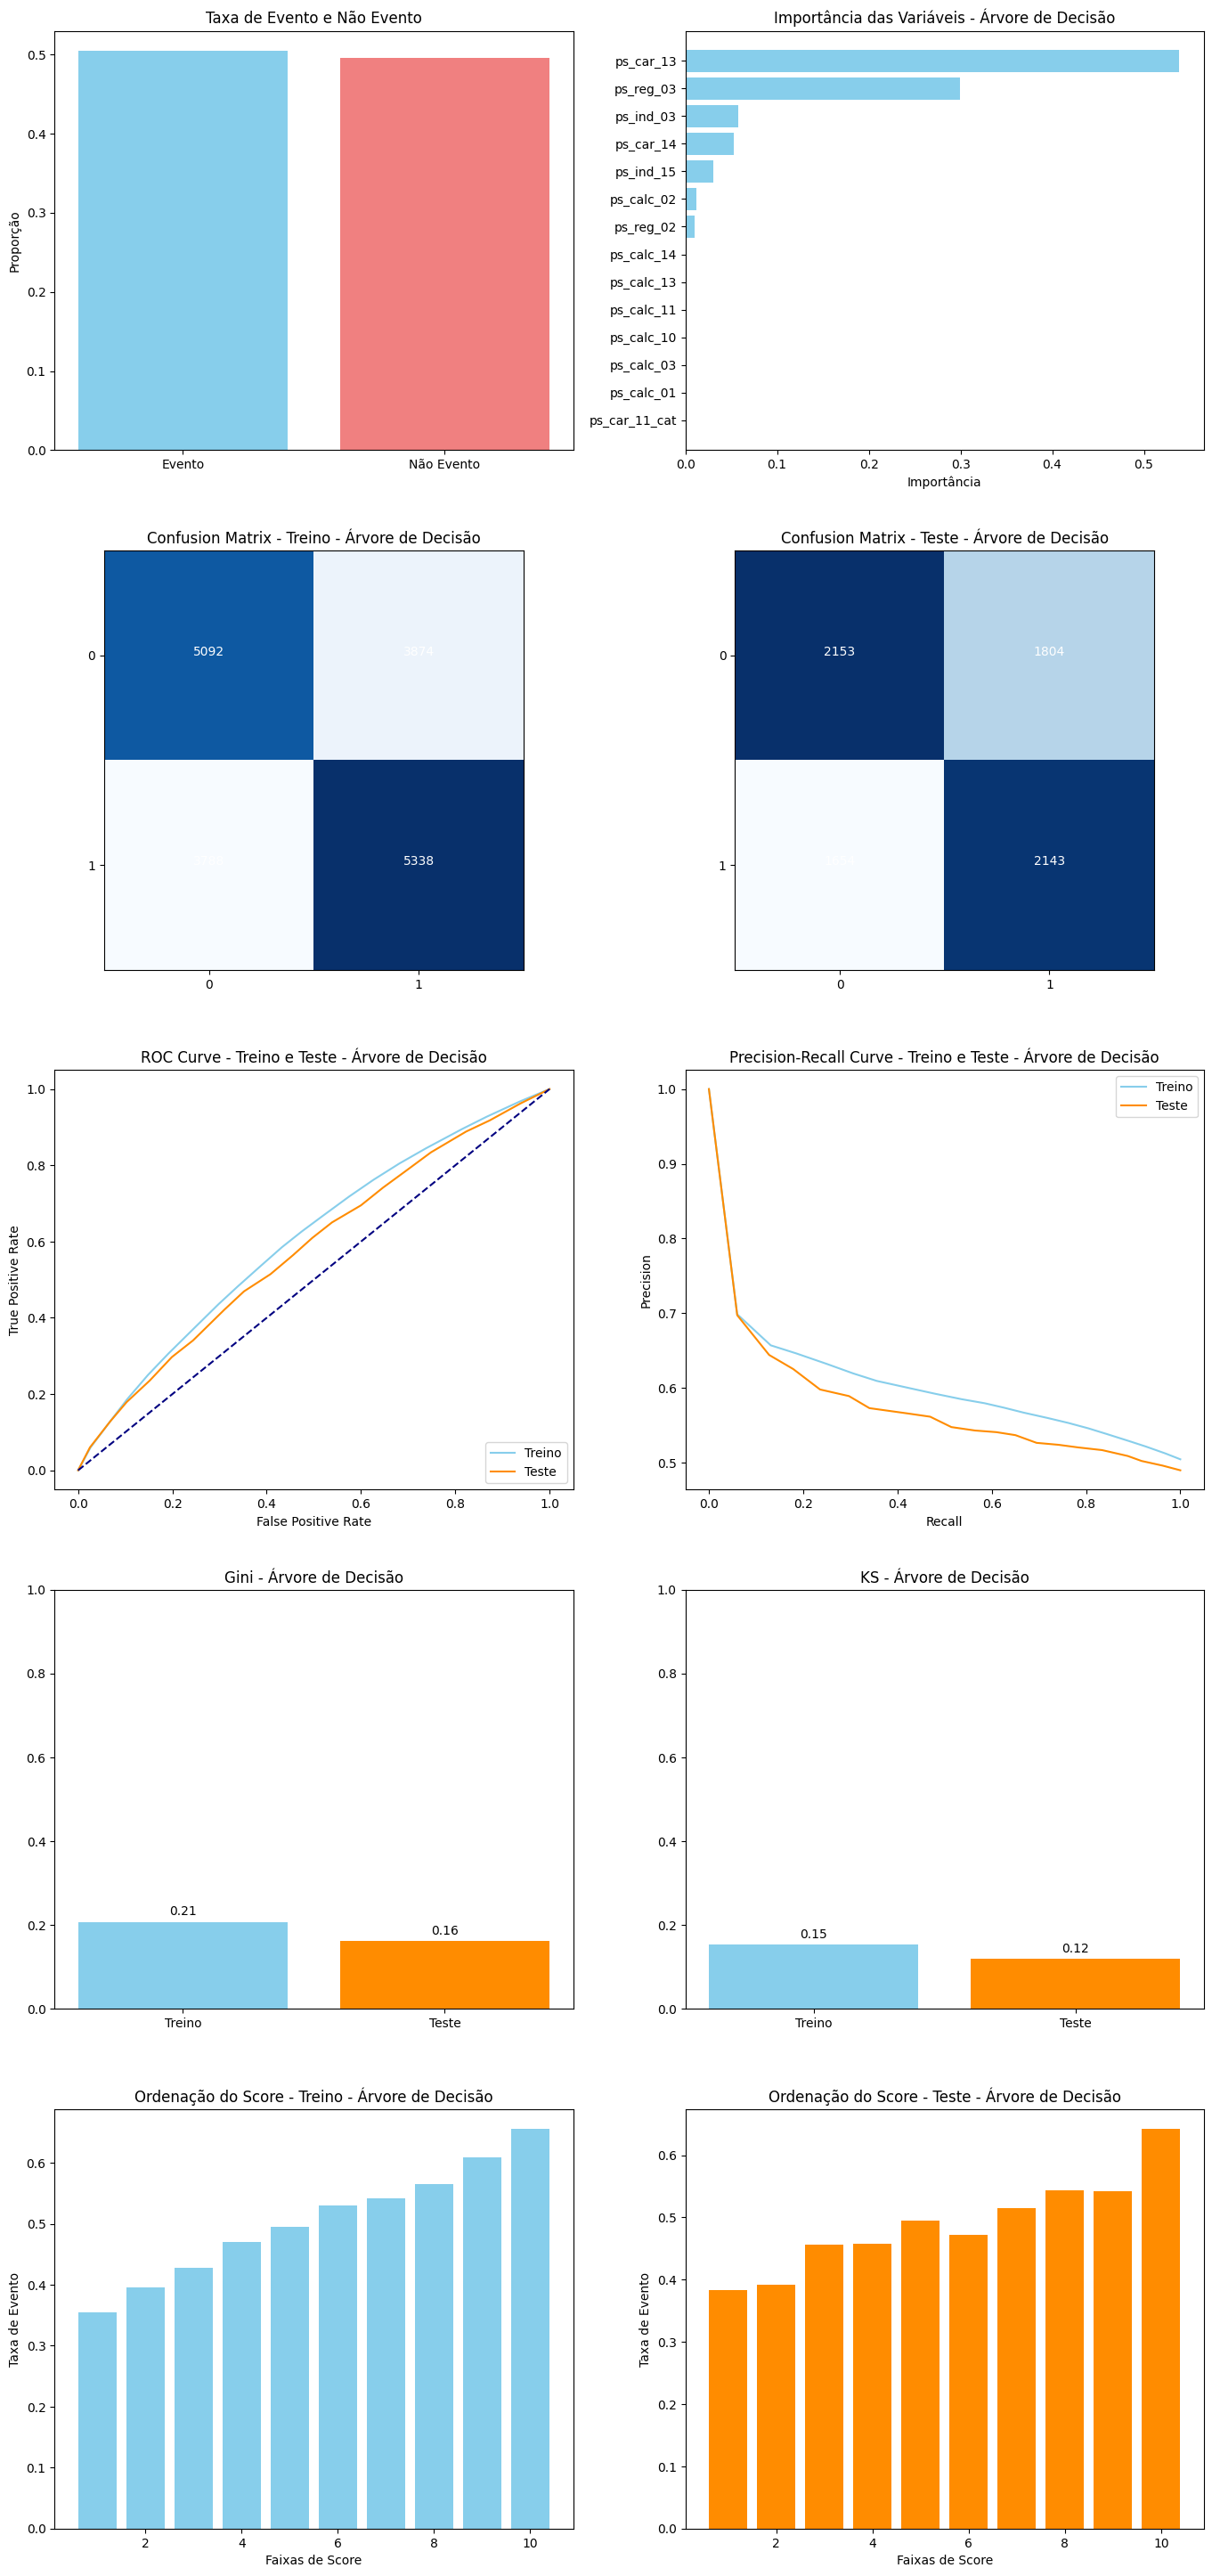

In [14]:
pod.avaliar_modelo(X_train, y_train, X_test, y_test, best_model_dt, nm_modelo='Árvore de Decisão')

In [15]:
from sklearn.linear_model import LogisticRegression

# Definindo o modelo
model = LogisticRegression(max_iter=100)
model_sgs = LogisticRegression(max_iter=100)

# penalty='l2', # Tipo de regularização: 'l1', 'l2', 'elasticnet', 'none'
# dual=False, # Formulação primal e dual do problema de otimização da regressão logística, sendo recomendado manter como False quando temos mais amostras do que Variáveis
# tol=0.0001, # Tolerância para critério de parada.
# C=1.0, # Inverso da força de regularização; deve ser um valor flutuante positivo. Como valores menores, especifica uma regularização mais forte.
# fit_intercept=True, # Especifica se uma constante (ou seja, viés ou interceptação) deve ser adicionada à função de decisão.
# intercept_scaling=1, # Útil apenas quando o solver 'liblinear' é usado e self.fit_intercept é definido como True.
# class_weight=None, # Pesos associados às classes. Se não for fornecido, todas as classes são supostas ter peso um.
# random_state=None, # Semente usada pelo gerador de números aleatórios.
# solver='lbfgs', # Algoritmo a ser usado no problema de otimização: {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, padrão='lbfgs'
# max_iter=100, # Número máximo de iterações para os solvers convergirem.
# multi_class='auto', # Se a opção escolhida for 'ovr', então um problema binário é ajustado para cada rótulo. Para 'multinomial', a perda minimizada é a perda multinomial ajustando todo o conjunto de dados de uma vez.
# verbose=0, # Para o solver 'liblinear' e 'lbfgs', defina o valor para qualquer inteiro positivo para classificar a verbosidade.
# warm_start=False, # Quando definido como True, reutiliza a solução da chamada anterior para ajustar como inicialização, caso contrário, apenas apaga a solução anterior.
# l1_ratio=None # O valor de Elastic-Net mixing parameter, com 0 <= l1_ratio <= 1. Somente usado se penalty='elasticnet'.


In [16]:
# Definindo os parametros para o grid search
param_grid = {
    'penalty':['l1','l2'],
    'tol':[0.00001,0.0001,0.001],
    'C': [1.0, 2.0],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced', {0:1,1:2}, {0:2,1:1}]
}

# Calculando a quantidade total de modelos que serão treinados
num_models = len(param_grid['penalty']) * len(param_grid['tol']) * len(param_grid['C']) * len(param_grid['solver']) * 5 # // retirado devido ao numero de modelos * len(param_grid['class_weight']) -  5 é o número de folds na validação cruzada (cv - cross-validation)

print(f"Total de Modelos a serem Treinados: {num_models}")

Total de Modelos a serem Treinados: 120


In [17]:
# Definindo o objetov GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='roc_auc',
                    n_jobs=-1
                    )

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# Treinamendo o modelo sem grid search para comparação
model_sgs.fit(X_train, y_train)

# Visualizar os melhores parametros encontrados pelo grid search
print('Melhores Parâmetros: ', grid.best_params_)

# Exibir a melhor pontuação (score) atingida pelo modelo com os melhores parametros
print('Melhor AUC: ', grid.best_score_)

Melhores Parâmetros:  {'C': 1.0, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}
Melhor AUC:  0.5883028806638557


In [18]:
# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)

predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(pod.gini_normalizado(y_test, predprob[:,1]),2)
print('Gini Normalizado --> ', gini_n)

best_model_rl = grid.best_estimator_

Gini Normalizado -->  0.19


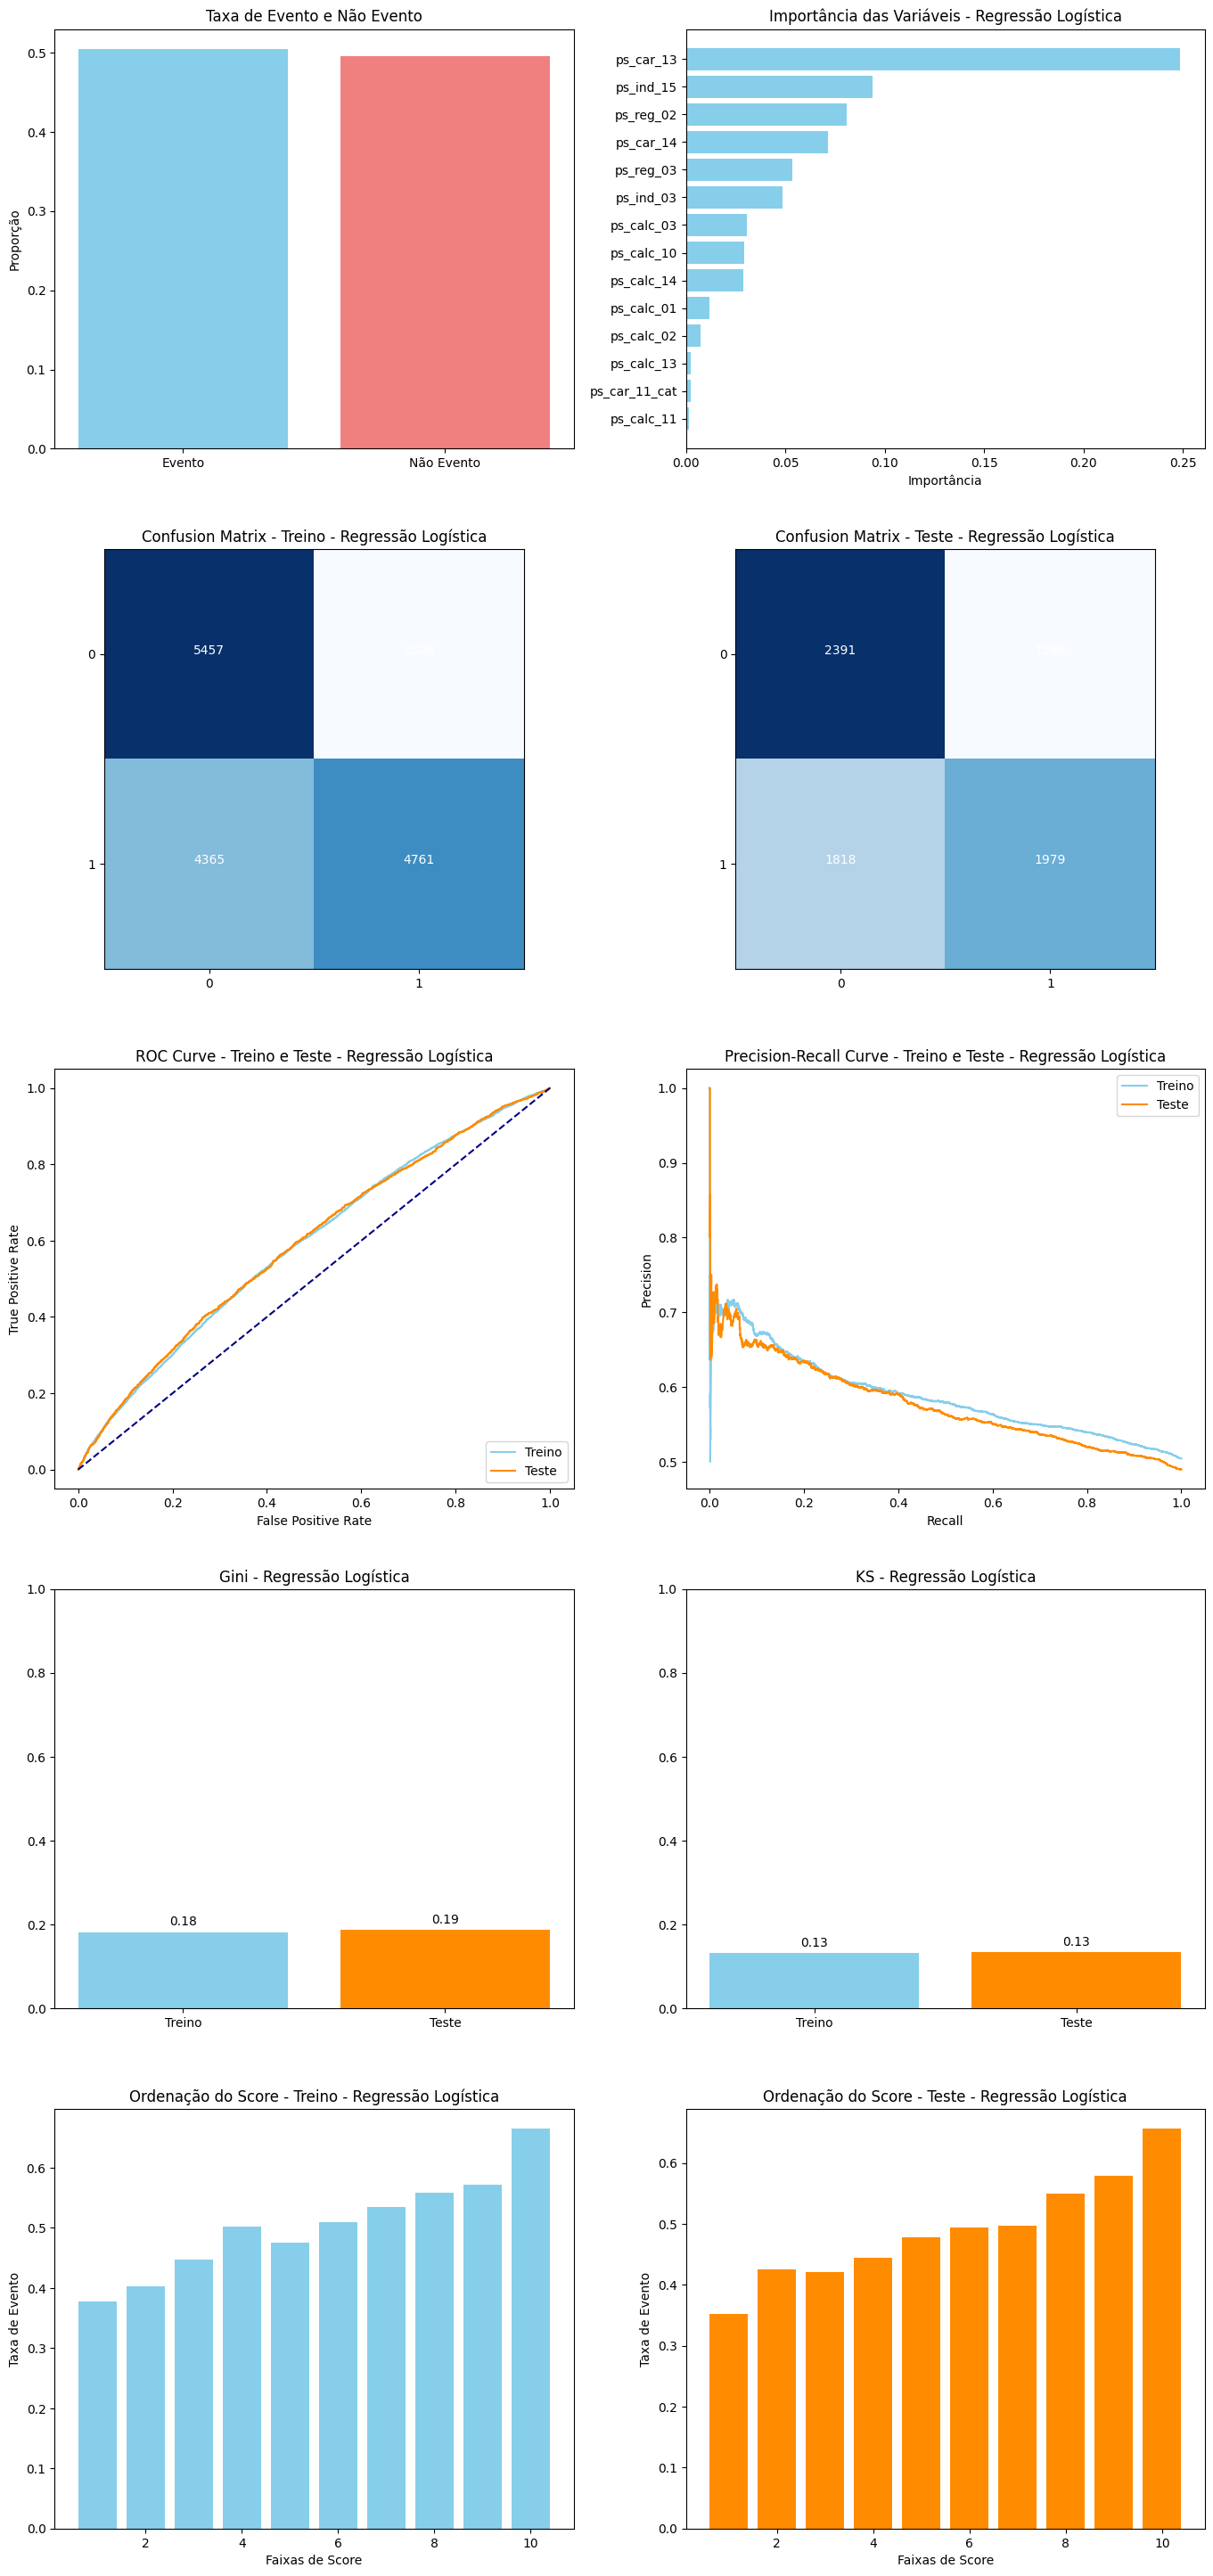

In [19]:
pod.avaliar_modelo(X_train, y_train, X_test, y_test, model_sgs, nm_modelo='Regressão Logística')

In [20]:
# Definindo o modelo
model = RandomForestClassifier(random_state=6)

# n_estimators=100,  # Número de árvores na floresta.
# criterion='gini',  # Função para medir a qualidade de uma divisão ("gini" ou "entropy").
# max_depth=None,  # Profundidade máxima das árvores. None significa que os nós são expandidos até ficarem puros.
# min_samples_split=2,  # Número mínimo de amostras necessárias para dividir um nó interno.
# min_samples_leaf=1,  # Número mínimo de amostras necessárias para estar em um nó folha.
# min_weight_fraction_leaf=0.0,  # Fração mínima ponderada da soma total de pesos necessária para estar em um nó folha.
# max_features='auto',  # Número de características a considerar ao procurar a melhor divisão.
# max_leaf_nodes=None,  # Número máximo de nós folha.
# min_impurity_decrease=0.0,  # Um nó será dividido se a divisão induzir a uma diminuição da impureza maior ou igual a este valor.
# bootstrap=True,  # Se as amostras de bootstrap são usadas ao construir árvores.
# oob_score=False,  # Se usar amostras out-of-bag para estimar a precisão generalizada.
# n_jobs=None,  # Número de jobs a serem executados em paralelo para ajuste e previsão. -1 significa usar todos os processadores.
# random_state=None,  # Controla a aleatoriedade do bootstrap e da seleção de features.
# verbose=0,  # Controla a verbosidade do processo de treinamento.
# warm_start=False,  # Reutiliza a solução da chamada anterior para ajustar e adicionar mais estimadores ao ensemble.
# class_weight=None  # Pesos associados às classes. Pode ser "balanced", "balanced_subsample" ou um dicionário com os pesos.




In [21]:
# Definindo os parâmetros para o grid search
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [2, 3, 5],
    'min_samples_split': [0.001, 0.01],
    'min_samples_leaf': [2, 0.01],
    'bootstrap': [True, False]
    #'max_features':['auto', 'sqrt', 'log2']
}

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='roc_auc',
                    n_jobs=-1
                    )
# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print('Melhores Parêmetros: ', grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print('Melhor AUC: ', grid.best_score_)

Melhores Parêmetros:  {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 0.001, 'n_estimators': 100}
Melhor AUC:  0.5953900780832494


In [22]:
# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)
predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(pod.gini_normalizado(y_test, predprob[:,1]),2)
print('Gini Normalizado --> ', gini_n)

best_model_rf = grid.best_estimator_

Gini Normalizado -->  0.19


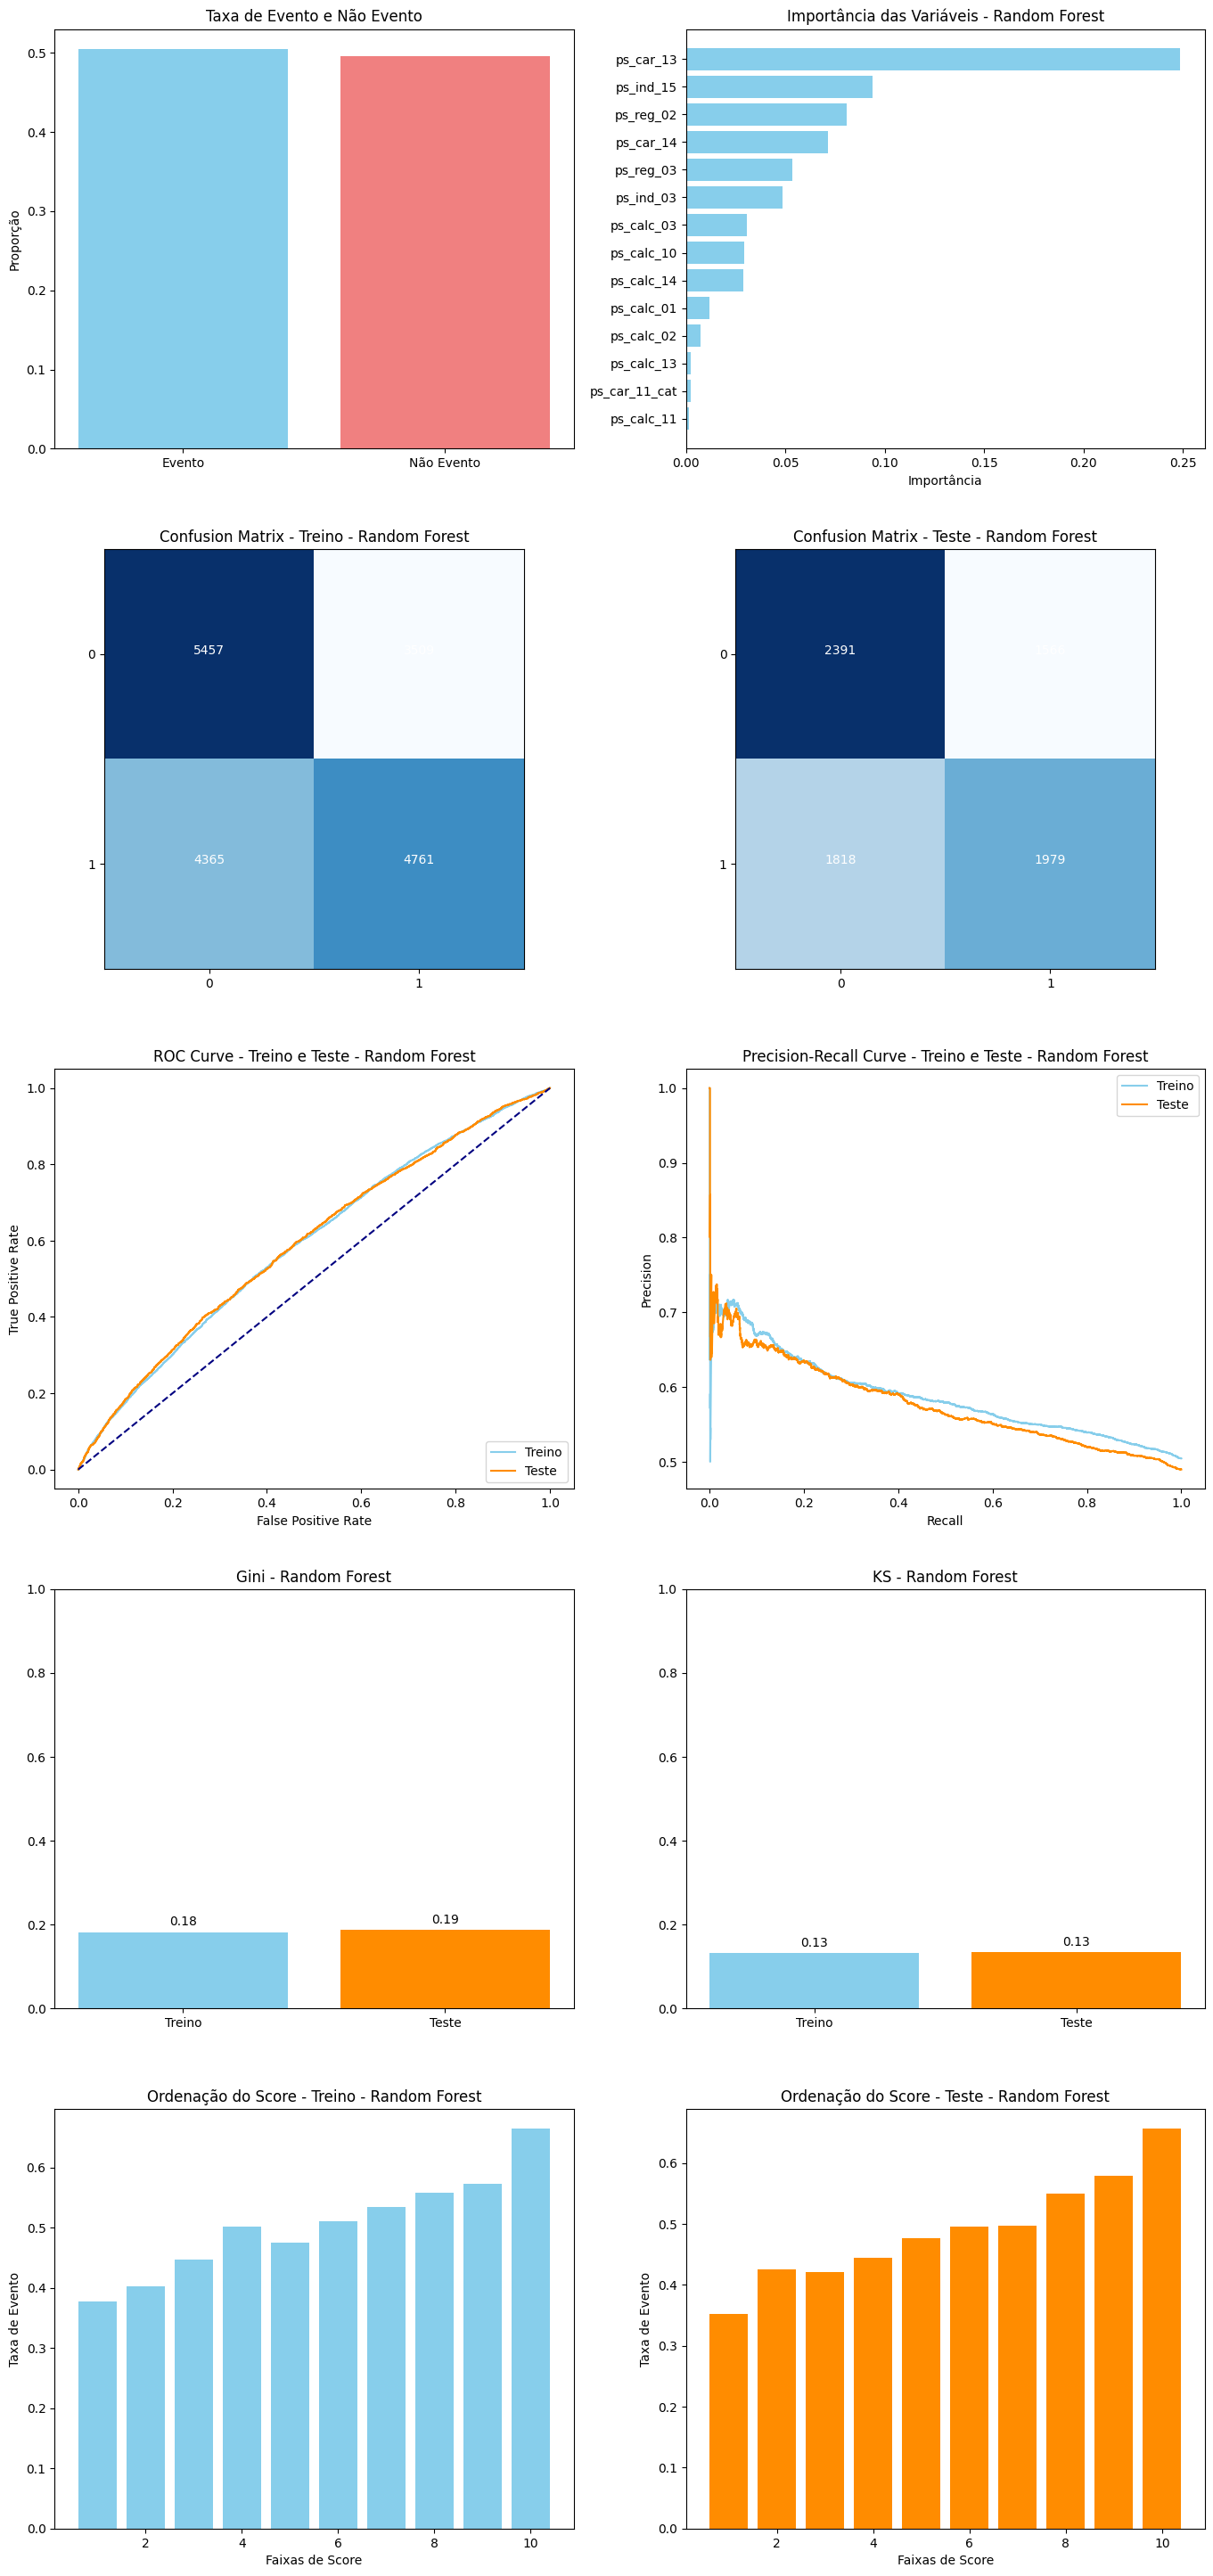

In [23]:
pod.avaliar_modelo(X_train, y_train, X_test, y_test, model_sgs, nm_modelo='Random Forest')

In [24]:
# Definindo o modelo
model = lgb.LGBMClassifier()

# Definindo os parâmetros para o grid search
param_grid = {
    'max_depth' : [3,5,7],
    'num_leaves': [5, 31],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [2, 5],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
}

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    verbose=2,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Info] Number of positive: 9126, number of negative: 8966
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1028
[LightGBM] [Info] Number of data p

In [25]:
# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)

predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(pod.gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

best_model_lightgbm = grid.best_estimator_

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
Gini normalizado -->  0.22


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is se

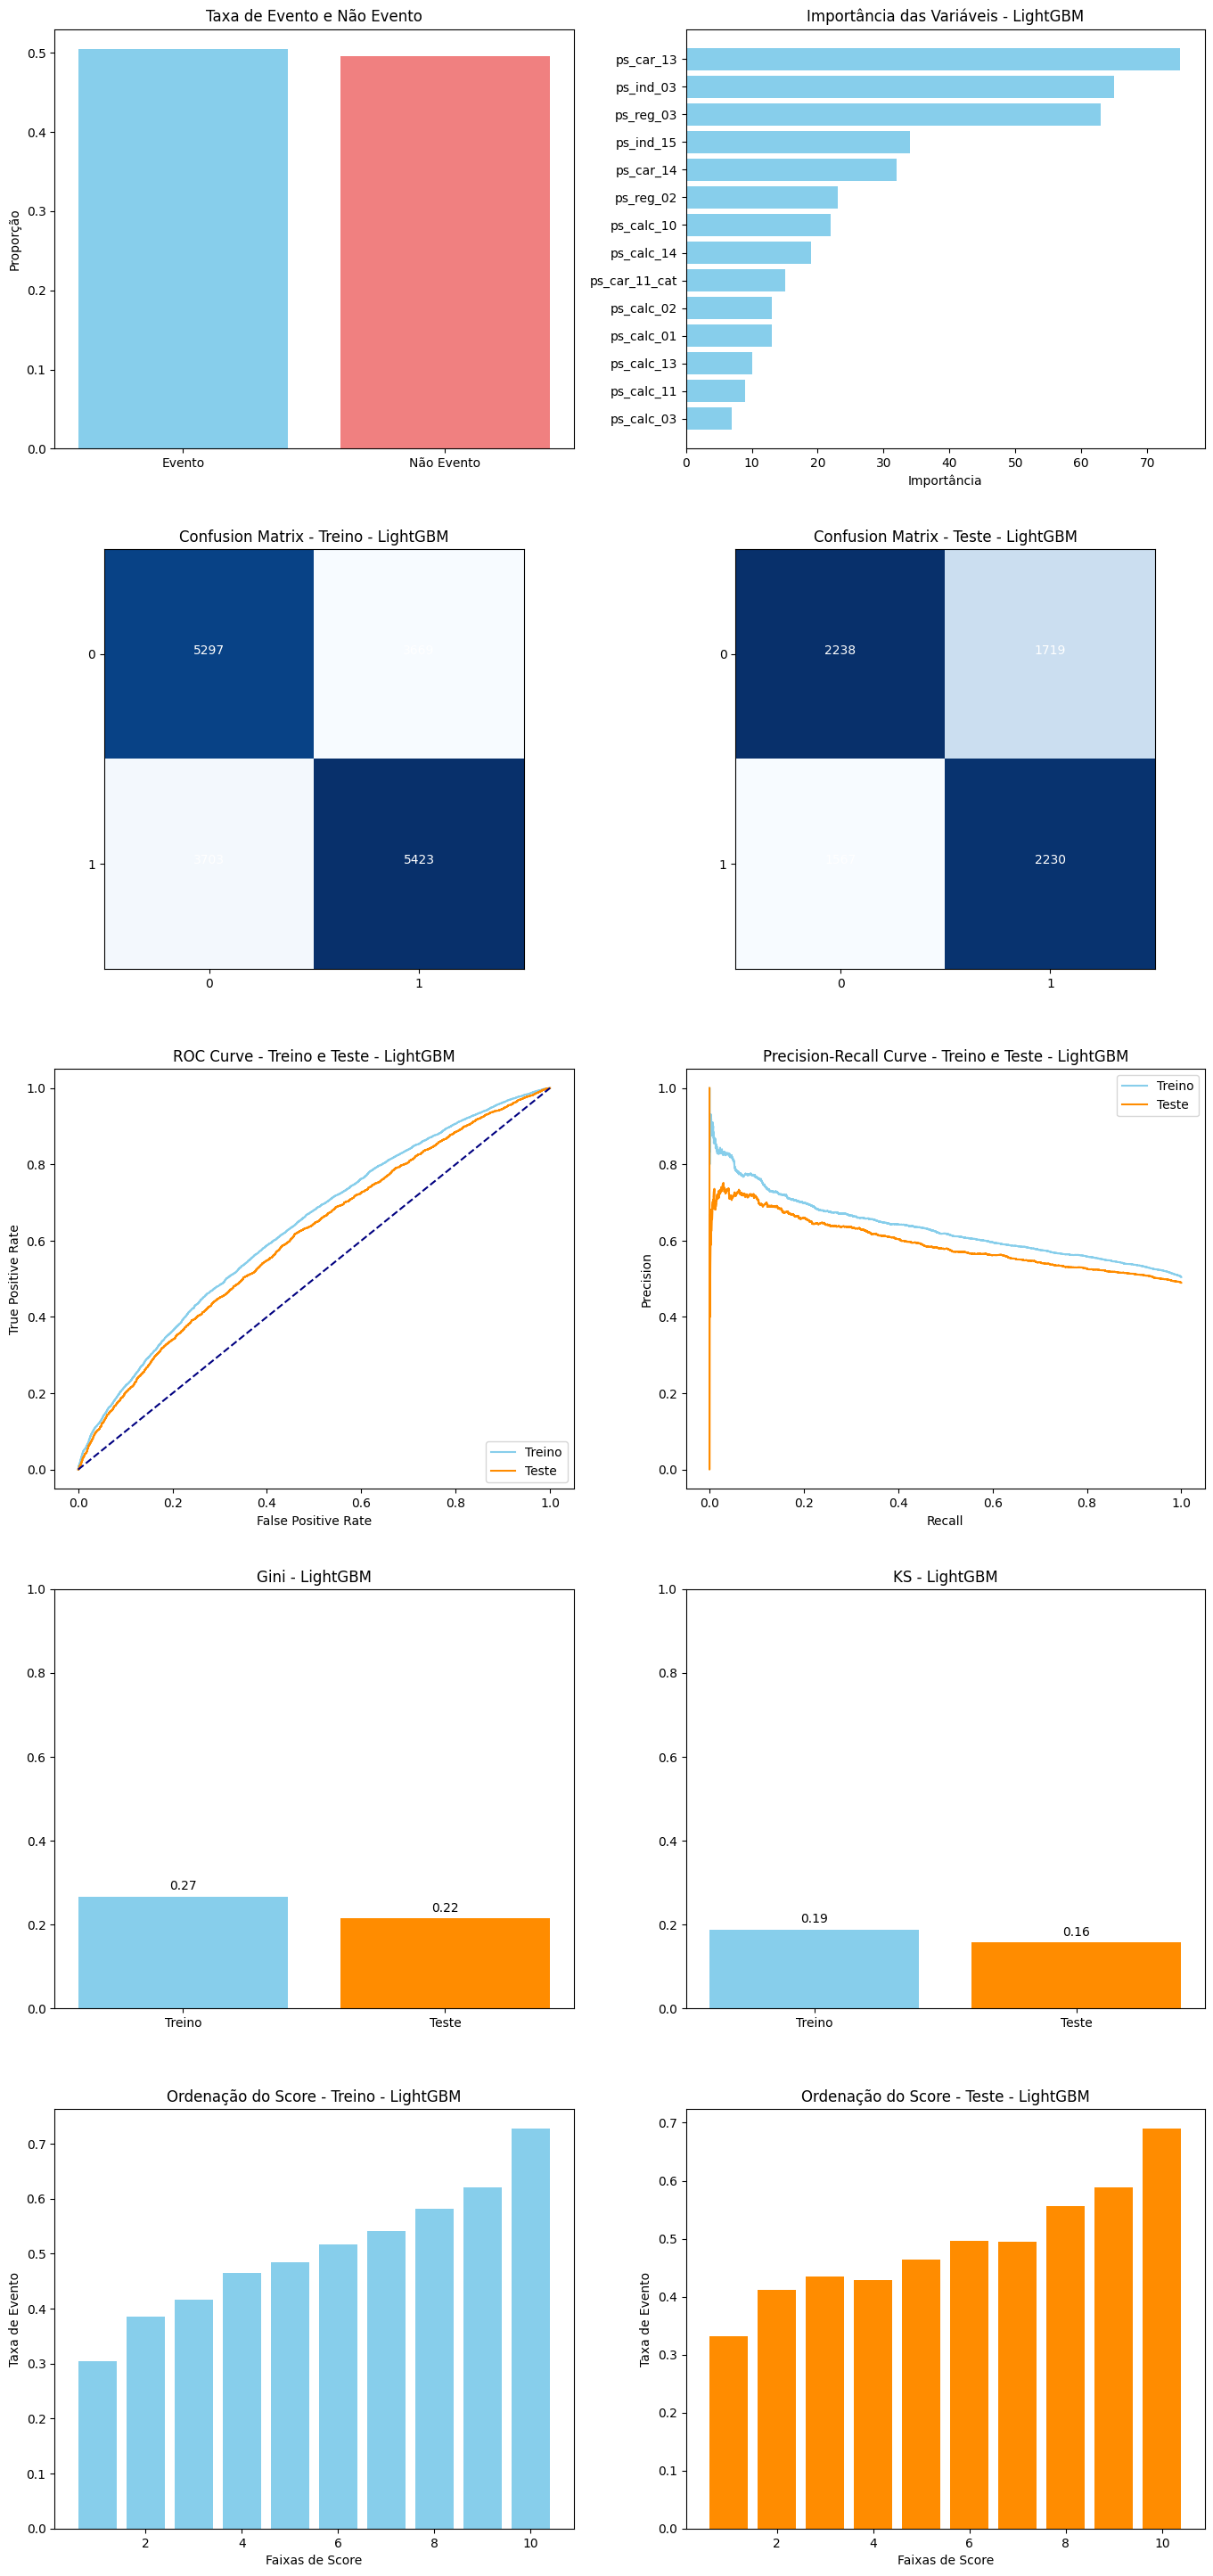

In [26]:
pod.avaliar_modelo(X_train, y_train, X_test, y_test, best_model_lightgbm,nm_modelo='LightGBM')

In [27]:
# Salvando artefatos dos modelos
import pickle

with open(dir_base + "artefatos_best_model_dt_fi.pkl", "wb") as f:
  pickle.dump(best_model_dt, f)

with open(dir_base + "artefatos_best_model_rl_fi.pkl", "wb") as f:
  pickle.dump(best_model_rl, f)

with open(dir_base + "artefatos_best_model_rf_fi.pkl", "wb") as f:
  pickle.dump(best_model_rf , f)

with open(dir_base + "artefatos_best_model_lightgbm_fi.pkl", "wb") as f:
  pickle.dump(best_model_lightgbm, f)

